#MIT 6.036 Spring 2019: Homework 8#

This colab notebook provides code and a framework for [homework 8](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.


# 2) Implementing Mini-batch Gradient Descent and Batch Normalization (OPTIONAL)

** Note: You can click the arrow on the left of this text block to collapse/expand this optional section and all its code blocks **

Last week we implemented a framework for building neural networks from scratch. We trained our models using *stochastic* gradient descent. In this problem, we explore how we can implement batch normalization as a module `BatchNorm` in our framework. It is the same module which you analyzed in problem 1.

Key to the concept of batch normalization is the doing gradient descent on batches of data. So we instead of using last week's stochastic gradient descent, we will first implement the *mini-batch* gradient descent method `mini_gd`, which is a hybrid between *stochastic* gradient descent and *batch* gradient descent. The lecture notes on <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week7/neural_networks_2/1?activate_block_id=block-v1%3AMITx%2B6.036%2B2019_Spring%2Btype%40vertical%2Bblock%40neural_networks_2_optimizing_neural_network_parameters_vert"> optimizing neural network parameters</a> are helpful for this part.

In *mini-batch* gradient descent, for a mini-batch of size $K$, we select $K$ distinct data points uniformly at random from the data set and update the network weights based only on their contributions to the gradient:
$$W := W - \eta\sum_{i=1}^K \nabla_W \mathcal{L}(h(x^{(i)}; W), y^{(i)})\;\;.$$

Our *mini-batch* method `mini_gd` will be implemented within the `Sequential` python class (see homework 7 problem 2) and will take the following as inputs:

* `X`: a standard data array (d by n)
* `y`: a standard labels row vector (1 by n)
* `iters`: the number of updates to perform on weights $W$
* `lrate`: the learning rate used
* `K`: the mini-batch size to be used

One call of `mini_gd` should call `Sequential.backward` for back-propagation and `Sequential.step` for updating the weights, for a total of `iters` times, using `lrate` as the learning rate. As in our implementation of `sgd` from homework 7, we compute the predicted output for a mini-batch of data with the `Sequential.forward` method. We compute the loss between our predictions and the true labels using the assigned `Sequential.loss` method. (Note that in homework 7, `Sequential.step` was called `Sequential.sgd_step`. While the functionality of the step function is the same, it has been renamed for convenience. The same is true for the `module.step` function of each module we implemented, where applicable.)

For picking $K$ unique data points at random from our large data-set for each mini-batch, we will implement the following strategy: we will first shuffle our data points `X` (and associated labels `y`). Then, we get <math>\frac{n}{k}</math> (rounded down to the nearest integer) different mini-batches by grouping each $K$ consecutive points from this shuffled array. If we end up iterating over all the points but need more mini-batches, we will repeat the shuffling and the batching process.

<b>2A)</b>You need to fill in the missing code below. We have implemented the shuffling of indices and have provided you with the outer and inner loops.

** This OPTIONAL problem has you extend your homework 7 implementation for building neural networks. **
### PLEASE COPY IN YOUR CODE FROM HOMEWORK 7 TO COMPLEMENT THE CLASSES GIVEN HERE

Recall that your implementation from homework 7 included the following classes:
    
  * Module
  * Linear
  * Tanh
  * ReLU
  * SoftMax
  * NLL
  * Sequential

In [8]:
import math as m

class Sequential:
    def __init__(self, modules, loss):
        self.modules = modules
        self.loss = loss

    def mini_gd(self, X, Y, iters, lrate, notif_each=None, K=10):
        D, N = X.shape

        np.random.seed(0)
        num_updates = 0
        indices = np.arange(N)
        loss = 0
        error = 0
        while num_updates < iters:

            np.random.shuffle(indices)
            X = X[:,indices]  # Your code
            Y = Y[:,indices]  # Your code

            for j in range(m.floor(N/K)):
                if num_updates >= iters: break
                Ypred = self.forward(X[:,j*K:j*(K+1)])
                loss = self.loss.forward(Ypred,Y[:,j*K:j*(K+1)])
                error = self.loss.backward()
                self.backward(error)
                self.sgd_step(lrate)
                num_updates += 1

    def forward(self, Xt):
        for m in self.modules: Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):
        for m in self.modules[::-1]: delta = m.backward(delta)

    def step(self, lrate):
        for m in self.modules: m.step(lrate)

<b>2B)</b> We are now ready to implement batch normalization into our neural network framework! Our module `BatchNorm` will sit between consecutive layers of neurons, such as the $l^{th}$ and $(l+1)^{th}$ layers, acting as a "corrector" which allows $W^l$ to change freely, producing outputs $z^l$, but then the module corrects the covariate shift induced in the signals before they reach the $(l+1)^{th}$ layer, converting $z^l$ to $\widehat{Z}^l$.

The following is a summmary what is described in the <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week7/neural_networks_2/2">lecture notes</a>, and it should guide your implementation of the module.

Any normalization between the $l^{th}$ and $(l+1)^{th}$ layers is done *separately* for each of the $n^l$ input connections leading to the $(l+1)^{th}$ layer. We handle a mini-batch of data of size $K$, and $Z^l$ is $n^l \times K$, and the output $\widehat{Z}^l$is of the same shape.

We first compute $n^l$ *batchwise* means and
standard deviations.  Let $\mu^l$ be the $n^l \times 1$ vector (`self.mus`) where
$$\mu^l_i = \frac{1}{K} \sum_{j = 1}^K Z^l_{ij}\;\;,$$
and let $\sigma^l$ be the $n^l \times 1$ vector (`self.vars`) where
$$\sigma^l_i = \sqrt{\frac{1}{K} \sum_{j = 1}^K (Z^l_{ij} - \mu_i)^2}\;\;.$$

The normalized data `self.norm` is the matrix $\overline{Z}$, where
$$\overline{Z}^l_{ij} = \frac{Z^l_{ij} - \mu^l_i}{\sigma^l_i + \epsilon}\;\;,$$
and where $\epsilon$ is a very small constant to guard against division by
zero.

We define weights $G^l$ (`self.G`) and $B^l$ (`self.B`), each being an $n^l \times 1$ vector, which we use to to shift and scale the outputs:
$$\widehat{Z}^l_{ij} = G^l_i \overline{Z}^l_{ij} + B^l_i\;\;.$$

The outputs are finally ready to be passed to the $(l+1)^{th}$ layer.

A slight warning (that we will not worry about here) about `BatchNorm` is that during the *test* phase, if the test mini-batch size is too small (imagine we are deploying a neural network that deals with live video frames), then the lack of samples would cause the freshly-calculated $\mu^l$ and $\sigma^l$ to be far off from their true values that the module's parameters $G^l$ and $B^l$ were trained to be compatible with. To fix that, people usually compute a running average of $\mu^l$ and $\sigma^l$ during training, to be used at test time. We will assume our test mini-batches are large enough.

In this problem we only implement the `BatchNorm.forward` and `BatchNorm.step` methods. We provide you with the implementation for `BatchNorm.backward` and the lecture notes contain the details of the derivations. You will need to fill in the missing code below.

In [9]:
import numpy as np

In [10]:
class Module:
    def sgd_step(self, lrate): pass  # For modules w/o weights


class Linear(Module):
    def __init__(self, m, n):
        self.m, self.n = (m, n)  # (in size, out size)
        self.W0 = np.zeros([self.n, 1])  # (n x 1)
        self.W = np.random.normal(0, 1.0 * m ** (-.5), [m, n])  # (m x n)

    def forward(self, A):
        self.A = A
        return np.dot(self.W.T, A) + self.W0  # (m x n)^T (m x b) = (n x b)

    def backward(self, dLdZ):  # dLdZ is (n x b), uses stored self.A
        self.dLdW = np.dot(self.A, dLdZ.T)                  # (m x n)
        self.dLdW0 = dLdZ.sum(axis=1).reshape((self.n, 1))  # (n x 1)
        return np.dot(self.W, dLdZ)                         # (m x b)

    def sgd_step(self, lrate):  # Gradient descent step
        self.W -= lrate*self.dLdW
        self.W0 -= lrate*self.dLdW0


class Tanh(Module):            # Layer activation
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A

    def backward(self, dLdA):    # Uses stored self.A
        return dLdA * (1.0 - (self.A ** 2))


class ReLU(Module):              # Layer activation
    def forward(self, Z):
        self.A = np.maximum(0, Z)
        return self.A

    def backward(self, dLdA):    # uses stored self.A
        return dLdA * (self.A != 0)


class SoftMax(Module):           # Output activation
    def forward(self, Z):
        return np.exp(Z) / np.sum(np.exp(Z), axis=0)

    def backward(self, dLdZ):    # Assume that dLdZ is passed in
        return dLdZ

    def class_fun(self, Ypred):  # Return class indices
        return np.argmax(Ypred, axis=0)


class NLL(Module):       # Loss
    def forward(self, Ypred, Y):
        self.Ypred = Ypred
        self.Y = Y
        return float(np.sum(-Y * np.log(Ypred)))

    def backward(self):  # Use stored self.Ypred, self.Y
        return self.Ypred - self.Y


class Sequential:
    def __init__(self, modules, loss):            # List of modules, loss module
        self.modules = modules
        self.loss = loss

    def sgd(self, X, Y, iters=100, lrate=0.005):  # Train
        D, N = X.shape
        sum_loss = 0
        for it in range(iters):
            i = np.random.randint(N)
            Xt = X[:, i:i+1]
            Yt = Y[:, i:i+1]
            Ypred = self.forward(Xt)
            sum_loss += self.loss.forward(Ypred, Yt)
            err = self.loss.backward()
            self.backward(err)
            self.sgd_step(lrate)

    def forward(self, Xt):                        # Compute Ypred
        for m in self.modules: Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):                    # Update dLdW and dLdW0
        # Note reversed list of modules
        for m in self.modules[::-1]: delta = m.backward(delta)

    def sgd_step(self, lrate):                    # Gradient descent step
        for m in self.modules: m.sgd_step(lrate)

    def print_accuracy(self, it, X, Y, cur_loss, every=250):
        # Utility method to print accuracy on full dataset, should
        # improve over time when doing SGD. Also prints current loss,
        # which should decrease over time. Call this on each iteration
        # of SGD!
        if it % every == 1:
            cf = self.modules[-1].class_fun
            acc = np.mean(cf(self.forward(X)) == cf(Y))
            print('Iteration =', it, '	Acc =', acc, '	Loss =', cur_loss)


In [12]:
class BatchNorm(Module):
    def __init__(self, m):
        np.random.seed(0)
        self.eps = 1e-20
        self.m = m  # number of input channels

        # Init learned shifts and scaling factors
        self.B = np.zeros([self.m, 1])
        self.G = np.random.normal(0, 1.0 * self.m ** (-.5), [self.m, 1])

    # Works on m x b matrices of m input channels and b different inputs
    def forward(self, A):# A is m x K: m input channels and mini-batch size K
        # Store last inputs and K for next backward() call
        self.A = A
        self.K = A.shape[1]

        self.mus = np.mean(A, axis=1, keepdims=True)  # Your Code
        self.vars = np.mean((A - self.mus)**2, axis=1, keepdims=True)  # Your Code

        # Normalize inputs using their mean and standard deviation
        self.norm = (A - self.mus) / (np.sqrt(self.vars)+self.eps)  # Your Code

        # Return scaled and shifted versions of self.norm
        return self.G*self.norm + self.B  # Your Code

    def backward(self, dLdZ):
        # Re-usable constants
        std_inv = 1/np.sqrt(self.vars+self.eps)
        A_min_mu = self.A-self.mus

        dLdnorm = dLdZ * self.G
        dLdVar = np.sum(dLdnorm * A_min_mu * -0.5 * std_inv**3, axis=1, keepdims=True)
        dLdMu = np.sum(dLdnorm*(-std_inv), axis=1, keepdims=True) + dLdVar * (-2/self.K) * np.sum(A_min_mu, axis=1, keepdims=True)
        dLdX = (dLdnorm * std_inv) + (dLdVar * (2/self.K) * A_min_mu) + (dLdMu/self.K)

        self.dLdB = np.sum(dLdZ, axis=1, keepdims=True)
        self.dLdG = np.sum(dLdZ * self.norm, axis=1, keepdims=True)
        return dLdX

    def step(self, lrate):
        self.B = self.B - lrate*self.dLdB  # Your Code
        self.G = self.G - lrate*self.dLdG  # Your Code
        return

# 3) 2D Datasets

For the 2D datasets, we have provided the following function:


```
run_keras_2d(data_name, layers, epochs, split=0.25, display=True, trials=5)
```


where:

data_name is a string, such as '1', '2', etc.
layers is a list of Keras layer definitions for a Sequential model, e.g.
```
[Dense(input_dim=2, units=10, activation='relu'), Dense(units=2, activation='softmax')]
```

epochs is an integer indicating how many times to go through the data in training
split is a fraction of the training data to use for validation if a validation set is not defined
display whether to display result plots
verbose whether to print loss and accuracy (percent correctly labeled) each epoch
trials is an integer indicating how many times to perform the training and testing
2D Data
The two-class datasets have data_names: '1','2','3','4'. Target accuracies (percent correct) on the validation set are (99%, 90.5%, 96%, 94%).

In this problem, try the following 5 architectures, specified by the number of units in the hidden layers:

1: (0), 2: (10), 3: (100), 4: (10, 10), 5: (100, 100))
You may find the archs function in the code file to be helpful here.
Some of these questions ask for the "simplest" architecture; the list above is ordered starting with the simplest.

In [5]:
import importlib
import code_for_hw8_keras  # or the name of your .py file without the .py extension

importlib.reload(code_for_hw8_keras)


<module 'code_for_hw8_keras' from '/home/doumana/Desktop/Cours/MIT/Chapter8_ConvolutionalNeuralNetwork/code_for_hw8_keras.py'>

In [6]:
from code_for_hw8_keras import *
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.datasets import mnist
from keras import backend as K
from keras.initializers import VarianceScaling
from matplotlib import pyplot as plt

In [4]:
layer1 = keras.layers.Dense(units=3, activation='relu', use_bias=False)
run_keras_2d("3", archs(2)[0], 10, split=0.5, display=False, verbose=False, trials=1)

/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-14 12:16:52.820980: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {np.float64(0.0), np.float64(1.0)}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {np.float64(0.0), np.float64(1.0)}

Loss on validation set:0.13826999068260193 Accuracy on validation set: 0.949999988079071

Avg. validation accuracy: 0.949999988079071


(array([[ 2.84183705e-01,  9.97209950e-01],
        [-4.22725606e-01, -2.40543697e+00],
        [ 2.52094708e+00,  1.11913471e+00],
        [-6.11864335e-01, -3.04394204e-01],
        [-1.54098934e+00, -1.19598653e+00],
        [ 1.20849816e+00, -5.16103953e-01],
        [ 6.10165824e-01, -7.02758659e-01],
        [ 3.01511975e-01,  6.02119507e-01],
        [ 2.50246022e-01,  1.16369383e+00],
        [ 1.24289721e+00,  3.87016394e-01],
        [ 1.65836601e-01,  1.04371696e+00],
        [-9.03762539e-01, -1.97830405e+00],
        [-1.91870264e+00, -9.72408379e-01],
        [ 1.49376800e-01,  6.48015791e-01],
        [ 2.33610938e-02, -1.84518665e+00],
        [ 5.75533547e-01, -1.77035812e+00],
        [ 1.12891929e-01,  9.84968701e-01],
        [ 5.31870945e-01,  6.12922734e-03],
        [-3.12358157e-01, -1.47095439e+00],
        [ 2.98144973e-01,  5.57058930e-01],
        [-1.47211524e-01, -6.12836186e-01],
        [-2.91308358e-01, -1.32297240e+00],
        [-9.70534473e-01,  1.131

In [19]:
# Data Set "1"
run_keras_2d("1", archs(2)[0], 10, split=0.5, display=False, verbose=False, trials=5)

Keras FC: dataset= 1
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {np.float64(0.0), np.float64(1.0)}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {np.float64(0.0), np.float64(1.0)}

Loss on validation set:0.024647798389196396 Accuracy on validation set: 1.0

Loss on validation set:0.0020087214652448893 Accuracy on validation set: 1.0

Loss on validation set:0.0005524751031771302 Accuracy on validation set: 1.0

Loss on validation set:0.0002113914815708995 Accuracy on validation set: 1.0

Loss on validation set:9.295763447880745e-05 Accuracy on validation set: 1.0

Avg. validation accuracy: 1.0


(array([[ 1.96862898,  1.44127363],
        [ 2.25700566, -1.89274149],
        [-1.91691306,  0.75886448],
        [ 2.06195764,  2.31998623],
        [-3.88907945,  2.30446643],
        [ 1.89355443,  3.24950679],
        [ 2.05613845,  1.44361091],
        [ 2.84434654, -1.41521584],
        [ 1.99681481,  1.97402199],
        [-1.60720593, -1.58867565],
        [ 1.98536282,  2.24946478],
        [-1.81009295,  0.68727262],
        [-1.89414917, -2.11614913],
        [ 1.97191678, -2.75374433],
        [ 2.13516564,  1.38403861],
        [-2.54386933, -2.26534038],
        [-0.17785058,  0.91015757],
        [ 2.03014213,  1.69756641],
        [-2.99225506,  2.08202039],
        [-2.27010871, -2.02078228],
        [-2.72533702,  3.49181596],
        [-1.94201613, -2.37091824],
        [ 2.03075563,  1.67455711],
        [-0.0620667 ,  1.21967451],
        [ 2.04165737, -2.25172456],
        [ 2.62613117, -2.70763261],
        [-0.74358183,  0.47885752],
        [-1.55341786, -1.789

In [37]:
# Data Set "2"
run_keras_2d("2", archs(2)[2], 10, split=0.5, display=False, verbose=False, trials=5)

Keras FC: dataset= 2
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {np.float64(0.0), np.float64(1.0)}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {np.float64(0.0), np.float64(1.0)}

Loss on validation set:0.2977200150489807 Accuracy on validation set: 0.8650000095367432

Loss on validation set:0.24569836258888245 Accuracy on validation set: 0.9049999713897705

Loss on validation set:0.2250882089138031 Accuracy on validation set: 0.9100000262260437

Loss on validation set:0.21716779470443726 Accuracy on validation set: 0.9200000166893005

Loss on validation set:0.21515609323978424 Accuracy on validation set: 0.9150000214576721

Avg. validation accuracy: 0.903000009059906


(array([[-6.16310244e-01,  2.61525230e+00],
        [-1.32852528e+00,  8.72765446e-01],
        [-2.57254344e+00, -5.67245715e-01],
        [ 1.78788530e+00, -8.24769511e-01],
        [ 2.34431322e-01, -1.11400704e+00],
        [ 8.90807683e-01, -1.10688054e+00],
        [-1.52803357e+00,  1.06207542e-01],
        [-1.03110059e+00,  1.49793799e+00],
        [ 1.03561105e+00,  1.05972780e+00],
        [-1.08569185e+00,  8.57924729e-01],
        [-2.58470717e-01, -1.10330149e+00],
        [-1.46853464e+00,  1.57104828e+00],
        [ 2.98135036e-01,  4.43167581e-01],
        [ 1.25838984e+00,  8.14428936e-01],
        [ 8.74059390e-01, -1.19176435e+00],
        [ 2.93140733e-01,  2.09981566e-01],
        [ 1.66798937e+00, -9.63566174e-01],
        [-7.07188277e-01,  1.90105335e+00],
        [ 3.39392196e+00, -6.68161919e-01],
        [ 1.04884381e+00,  8.74936808e-01],
        [ 1.20175672e+00, -9.30735169e-01],
        [-8.19505075e-01,  3.12796208e+00],
        [ 2.36331478e-01,  1.698

In [ ]:
# Data Set "3"
run_keras_2d("3", archs(2)[0], 10, split=0.5, display=False, verbose=False, trials=5)

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {np.float64(0.0), np.float64(1.0)}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {np.float64(0.0), np.float64(1.0)}

Loss on validation set:0.1472764015197754 Accuracy on validation set: 0.9399999976158142

Loss on validation set:0.11362847685813904 Accuracy on validation set: 0.9649999737739563

Loss on validation set:0.1065865308046341 Accuracy on validation set: 0.9700000286102295

Loss on validation set:0.10415594279766083 Accuracy on validation set: 0.9750000238418579

Loss on validation set:0.1032845601439476 Accuracy on validation set: 0.9750000238418579

Avg. validation accuracy: 0.9650000095367431


(array([[ 5.31870945e-01,  6.12922734e-03],
        [-7.65561520e-01,  1.13055983e+00],
        [ 1.92377126e-01, -1.50177035e-01],
        [-5.68201865e-01,  9.97233331e-01],
        [-2.79335783e-01, -8.87909018e-01],
        [ 3.27494621e+00, -3.78799528e-01],
        [-1.10963737e+00, -7.21441528e-01],
        [-1.34882284e+00, -2.41377262e+00],
        [ 1.49376800e-01,  6.48015791e-01],
        [ 3.05757245e+00,  8.02533863e-02],
        [-5.02895716e-01,  1.03914579e+00],
        [-1.07412296e-01,  1.18497910e+00],
        [-1.89499918e-01,  8.55965739e-01],
        [-6.50672262e-01,  1.22474875e+00],
        [ 1.80089979e-01,  8.68041199e-01],
        [ 2.50246022e-01,  1.16369383e+00],
        [-5.76529670e-01, -9.03522018e-01],
        [-1.03777338e+00,  8.71249143e-01],
        [-1.25241081e-01,  7.65571558e-01],
        [ 8.49637322e-01, -1.29314599e-01],
        [-8.88840612e-01,  9.57599953e-01],
        [-9.17862713e-01, -1.28247051e+00],
        [-3.38696894e-01,  2.095

In [28]:
# Data Set "4"
run_keras_2d("4", archs(2)[1], 10, split=0.5, display=False, verbose=False, trials=5)

Keras FC: dataset= 4
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {np.float64(0.0), np.float64(1.0)}
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {np.float64(0.0), np.float64(1.0)}

Loss on validation set:0.12049038708209991 Accuracy on validation set: 0.9524999856948853

Loss on validation set:0.12097751349210739 Accuracy on validation set: 0.9549999833106995

Loss on validation set:0.1258094161748886 Accuracy on validation set: 0.9549999833106995

Loss on validation set:0.1257629096508026 Accuracy on validation set: 0.949999988079071

Loss on validation set:0.1339282989501953 Accuracy on validation set: 0.9524999856948853

Avg. validation accuracy: 0.9529999852180481


(array([[ 1.76807396, -0.34506929],
        [-3.28466848,  1.79050565],
        [ 2.03263457, -2.41172373],
        [ 2.15258086,  1.9715491 ],
        [ 1.9328414 ,  0.81284926],
        [ 2.27733248, -1.73979398],
        [-1.90093728, -1.65353849],
        [-0.92246285, -1.53445665],
        [-1.41920206, -2.22054865],
        [-2.3278879 ,  2.79841293],
        [ 1.97427491, -1.18920681],
        [-0.7595114 ,  2.29178466],
        [-1.70438707, -0.64324465],
        [-0.3877901 ,  0.18963373],
        [-2.1021045 ,  0.83507467],
        [ 2.92922854, -0.37685208],
        [-1.59485026, -2.61252413],
        [ 3.58443511, -1.48093887],
        [-2.2497606 ,  2.65883001],
        [-1.73412068,  1.26295384],
        [ 2.10713123, -2.29350289],
        [-0.3160095 , -2.73601242],
        [-0.51161171, -3.65950289],
        [ 1.72318149,  0.96261346],
        [ 1.68032797,  1.0314589 ],
        [ 1.27022279, -3.80458758],
        [ 1.35166346, -3.3517343 ],
        [ 1.58488197,  0.433

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {np.float64(0.0), np.float64(1.0)}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {np.float64(0.0), np.float64(1.0)}
Epoch 1/100


/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9490 - loss: 0.2315 - val_accuracy: 0.9550 - val_loss: 0.1203
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9727 - loss: 0.0920 - val_accuracy: 0.9600 - val_loss: 0.1159
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9617 - loss: 0.0992 - val_accuracy: 0.9700 - val_loss: 0.1215
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9737 - loss: 0.0480 - val_accuracy: 0.9650 - val_loss: 0.1195
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9755 - loss: 0.0695 - val_accuracy: 0.9650 - val_loss: 0.1236
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9812 - loss: 0.0636 - val_accuracy: 0.9750 - val_loss: 0.1131
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9802 - loss: 0.0527 - val_accuracy: 0.9650 - val_loss: 0.1151
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9723 - loss: 0.0676 - val_accuracy: 0.9650

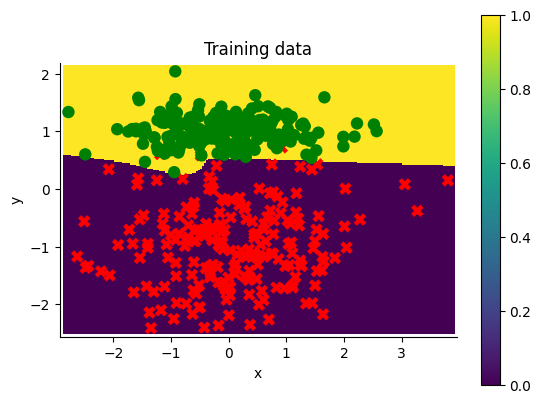

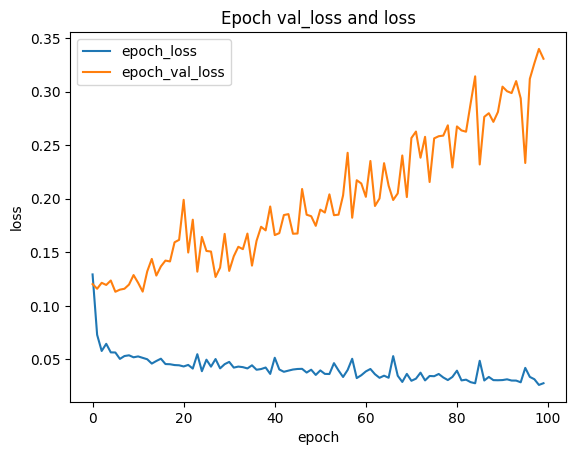

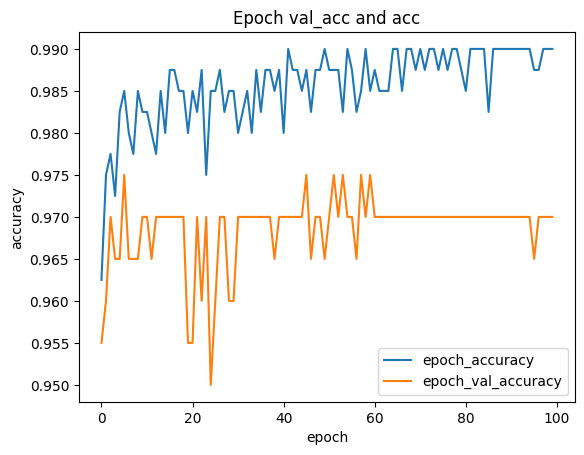


Avg. validation accuracy: 0.9700000286102295


(array([[-1.14914412e-01, -1.66416399e-01],
        [ 3.27494621e+00, -3.78799528e-01],
        [-2.09114448e-01,  4.01341583e-01],
        [ 8.25923398e-01,  1.33663561e+00],
        [ 1.61892082e-02,  7.50985464e-01],
        [ 1.25180445e+00, -1.31323403e+00],
        [-1.03777338e+00,  8.71249143e-01],
        [ 6.82230917e-01,  1.43235646e+00],
        [-1.42672828e+00, -1.68955108e+00],
        [ 2.69701928e-01, -3.44847643e-01],
        [-8.19227913e-01,  1.13638010e+00],
        [-5.09257270e-01,  1.47036827e+00],
        [-9.17862713e-01, -1.28247051e+00],
        [-1.07724068e+00, -9.62656450e-01],
        [-1.33650871e-01, -9.32036395e-01],
        [-9.10797208e-01, -1.51408134e+00],
        [-6.24272716e-01,  1.25215523e+00],
        [ 7.74771870e-01, -1.12994088e+00],
        [-2.80759883e-01, -6.54796310e-01],
        [-9.70534473e-01,  1.13151763e+00],
        [ 2.56817317e+00,  1.00347317e+00],
        [-2.19315340e-01,  1.31915105e+00],
        [ 3.59454556e-02, -4.945

In [54]:
layer = [Dense(input_dim=2, units=100, activation='relu'),
             Dense(units=100, activation='relu'),
             Dense(units=2, activation="softmax")]
run_keras_2d("3", layer, 100, split=0.5, display=True, verbose=True, trials=1)

In [62]:
run_keras_2d("3class", archs(3)[4], 10, split=0.5, display=False, verbose=False, trials=5)

Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {np.float64(0.0), np.float64(1.0), np.float64(2.0)}

Loss on validation set:0.12197011709213257 Accuracy on validation set: 0.9624999761581421

Loss on validation set:0.1307942271232605 Accuracy on validation set: 0.9700000286102295

Loss on validation set:0.13666291534900665 Accuracy on validation set: 0.9599999785423279

Loss on validation set:0.16762077808380127 Accuracy on validation set: 0.9599999785423279

Loss on validation set:0.16222789883613586 Accuracy on validation set: 0.9700000286102295

Avg. validation accuracy: 0.9644999980926514


(array([[ 0.12531637,  1.84633425],
        [-0.19185221, -0.65822462],
        [-1.69860724,  1.6052933 ],
        ...,
        [-1.97815764, -1.49690197],
        [-0.97418566, -0.94600841],
        [-2.25278666, -1.42970498]]),
 array([1., 0., 2., 2., 1., 2., 2., 0., 2., 2., 2., 1., 2., 0., 0., 2., 2.,
        1., 0., 0., 1., 1., 2., 2., 1., 2., 0., 2., 2., 0., 2., 0., 2., 1.,
        1., 2., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1., 2., 2., 2., 1., 1.,
        1., 2., 0., 0., 1., 1., 1., 1., 1., 0., 1., 2., 2., 1., 0., 1., 1.,
        2., 0., 0., 0., 0., 1., 2., 1., 1., 1., 0., 0., 2., 2., 2., 0., 1.,
        0., 0., 2., 0., 2., 0., 0., 0., 1., 1., 2., 0., 1., 0., 0., 1., 2.,
        1., 0., 0., 1., 2., 1., 0., 2., 0., 1., 2., 0., 2., 1., 2., 1., 0.,
        0., 1., 2., 2., 1., 2., 2., 0., 0., 1., 0., 1., 1., 0., 1., 0., 2.,
        0., 1., 0., 0., 1., 1., 1., 2., 1., 0., 1., 0., 2., 0., 2., 1., 1.,
        0., 1., 2., 1., 2., 0., 1., 0., 0., 1., 0., 0., 2., 2., 0., 1., 2.,
        2

In [95]:
X_train, y, model = run_keras_2d("3class", archs(3)[0], 10, split=0.5, display=False, verbose=False, trials=5)
W, W0 = model.layers[-1].get_weights()

/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Keras FC: dataset= 3class
Loading X (800, 2) y (800,) classes {np.float64(0.0), np.float64(1.0), np.float64(2.0)}

Loss on validation set:0.31759050488471985 Accuracy on validation set: 0.9175000190734863

Loss on validation set:0.296957403421402 Accuracy on validation set: 0.9075000286102295

Loss on validation set:0.2921251952648163 Accuracy on validation set: 0.9100000262260437

Loss on validation set:0.28987812995910645 Accuracy on validation set: 0.9100000262260437

Loss on validation set:0.28906339406967163 Accuracy on validation set: 0.9100000262260437

Avg. validation accuracy: 0.9110000252723693


In [97]:
inputs = np.array([[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]])
Z = np.dot(inputs, W) + W0
def softmax(z):
    exp_z = np.exp(z)  
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)
prob = softmax(Z)
pred = np.argmax(prob, axis=1)
for i, point in enumerate(inputs):
    print(f"Input: {point}, z: {Z[i]}, Probabilities: {prob[i]}, Prediction: Class {pred[i]}")


Input: [-1  0], z: [ 0.3014009  -2.85762846  0.9049255 ], Probabilities: [0.34830835 0.01479159 0.63690006], Prediction: Class 2
Input: [1 0], z: [-1.1222657   3.14791095 -0.54828843], Probabilities: [0.01345721 0.96265201 0.02389078], Prediction: Class 1
Input: [  0 -11], z: [ 18.06843799 -11.29916203 -14.12923536], Probabilities: [1.00000000e+00 1.76121900e-13 1.03926938e-14], Prediction: Class 0
Input: [0 1], z: [-2.09032971  1.18553245  1.47900525], Probabilities: [0.01588335 0.42036925 0.5637474 ], Prediction: Class 2
Input: [-1 -1], z: [ 1.98129821 -3.89801967 -0.39576122], Probabilities: [0.91272536 0.00255261 0.08472202], Prediction: Class 0
Input: [-1  1], z: [-1.37849641 -1.81723726  2.20561221], Probabilities: [0.02654908 0.01712012 0.9563308 ], Prediction: Class 2
Input: [1 1], z: [-2.802163    4.18830216  0.75239828], Probabilities: [8.91107464e-04 9.67944660e-01 3.11642324e-02], Prediction: Class 1
Input: [ 1 -1], z: [ 0.55763161  2.10751975 -1.84897515], Probabilities: [

# Weight sharing (OPTIONAL)

** Note: You can click the arrow on the left of this text block to collapse/expand this optional section and all its code blocks **

In the lab we designed a CNN that can count the number of objects in 1 dimensional images, where each black pixel is represented by a value of 0 and each white pixel is represented by a value of 1. Recall that an object is a consecutive sequence of black pixels ($0$'s). For example, the sequence $0100110$ contains three objects.

Here we want to see how hard/easy it is to train such a network from data.  Our network architecture will be as follows:

* The first layer is convolutional and you will implement it using the Keras `Conv1D` function, with a kernel of size 2 and stride of 1 with ReLu activation.

* The second layer is a fully connected `Dense` layer which has a scalar output.

Here is sample usage of the `Conv1D` and`Dense` layers.

`layer1=keras.layers.Conv1D(filters=?, kernel_size=?, strides=?,use_bias=False, activation=?, batch_size=1, input_shape=?, padding='same')`

`Dense(units=?, activation=?, use_bias=False)`

You need to fill in the parameters marked with `?` based on the problem specifications. Note also that in Keras, depending on your implementation, you may be forced to use *three* layers to implement such a network, where one intermediary `Flatten` layer is used to flatten the output of the convolutional layer, before being passed to the dense layer.

Refer to the <a href="https://keras.io/layers/convolutional/">Conv 1D</a>, <a href="https://keras.io/layers/core/">Dense</a> and <a href="https://keras.io/layers/core/#flatten">Flatten</a> descriptions in the Keras documentation to see the available parameter options.

In this exercise, we fix the structure and want to learn the best combination of weights from data. In the homework code, we have provided functions `train_neural_counter` and `get_image_data_1d`. You can use them to generate data and train the above neural network in Keras to answer the following questions. We assume that the images in our data set are randomly generated. The probability of a pixel being white is $0.1$. We work with mean squared error as the loss function for this problem. We have provided template code which you can fill in, to perform the training.

<b>4B)</b> What is (approximately) the expected loss of the network on $1024\times 1$ images if the convolutional layer is an averaging filter and second layer is the sum function (without a bias term)? (Note that you can answer the question theoretically or through coding, depending on your preference.)

In [98]:
from keras.models import Sequential

In [10]:
# Code template if you would like to check 4B) through code

imsize = 1024
prob_white = 0.1

num_filters = 1  # Your code
kernel_size = 2  # Your code
strides = 1 # Your code
activation_conv = 'relu'  # Your code

(X_train,Y_train,X_val,Y_val,X_test,Y_test) = get_image_data_1d(1000,imsize,prob_white)

layer1=keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, \
       strides=strides, use_bias=False, activation=activation_conv, input_shape=(imsize,1), padding='same')

activation_dense = 'linear'  # Your code
num_units = 1  # Your code
layer3=Dense(units=num_units, activation=activation_dense, use_bias=False)

layers=[layer1,Flatten(),layer3]

# This is how we create the model using our layers
model=Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss='mse', optimizer=Adam())

# Set the weights of the layers to desired values
# We give you the lines to use for this part
model.layers[0].set_weights([np.array([1/2,1/2]).reshape(2,1,1)])
model.layers[-1].set_weights([np.ones(imsize).reshape(imsize,1)])

model.evaluate(X_test,Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94.2095 


97.42900085449219

<b>4C)</b> Now suppose we add a bias term of $-10$ to the last layer. What is (approximately) the expected quadratic loss? (Note that you can answer the question theoretically or through coding, depending on your preference.)

In [12]:
layer3=Dense(units=num_units, activation=activation_dense, use_bias=True)

layers=[layer1,Flatten(),layer3]

# This is how we create the model using our layers
model=Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss='mse', optimizer=Adam())

# Set the weights of the layers to desired values
# We give you the lines to use for this part
model.layers[0].set_weights([np.array([1/2,1/2]).reshape(2,1,1)])
model.layers[-1].set_weights([np.ones(imsize).reshape(imsize,1),np.array([-10])])

model.evaluate(X_test,Y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.6165


11.928999900817871

<b>4D)</b> Averaging type filters are abundant and form a nearly flat valley of local minima for this problem. It is difficult for the network to find alternative solutions on its own. We need to force our way out of these bad minima and towards a better solution, i.e., an edge detector. To force the first layer to behave as an edge detector, we need to choose a proper **kernel regularizer**. Consider the following functions

$f_1=\sum_i |w_i|$, $f_2=\sum_i |w_i^2|$, $f_3=|\sum_{i} w_i|$. Which one of the choices is likely to guide the network to find an edge detector at the convolution layer?


<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to Catsoop.</a>

Implement your choice of regularizers from above in the code (complete the function `filter_reg`). Do not allow any bias in the layers for the rest of the problem. The code generates some random test and training data sets and trains the model on these data. Run a few learning trials (5 or more) for each data set and answer the following questions based on the performance of your model.

**IMPORTANT**: When implementing `filter_reg`, you should use the keras backend operations, imported as "K" in the code. So for example, `K.sum` and `K.abs`, rather than `np.sum` and `np.abs`. This is because the `weights` argument is NOT a numpy object, but rather an internal Keras object!

In [7]:
from keras.regularizers import Regularizer
import keras.backend as K

class FilterRegularizer(Regularizer):
    def __init__(self, lam=1000):
        self.lam = lam

    def __call__(self, weights):
        filter_result = keras.ops.absolute(keras.ops.sum(weights))
        return self.lam * filter_result  
    
filter_reg = FilterRegularizer(lam=1000)


<b>4E)</b> For $1024\times 1$ images and training set of size $1000$, is the network **without any regularization** likely to find models that have a mean square error lower than 8 on the test data?

In [56]:

filter_reg = FilterRegularizer(10)
imsize = 1024
prob_white = 0.1

data=get_image_data_1d(1000, imsize, prob_white)
trials=5
mean_err = 0
errors = []
for trial in range(trials):

    num_filters = 1  # Your code
    kernel_size = 2  # Your code
    strides = 1 # Your code
    activation_conv = 'relu'  # Your code


    layer1=keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, \
    strides=strides, use_bias=False, activation=activation_conv, \
    input_shape=(imsize,1),padding='same',kernel_regularizer=filter_reg)

    activation_dense = 'linear'  # Your code
    num_units = 1  # Your code

    layer3=Dense(units=num_units, activation=activation_dense, use_bias=False)

    layers=[layer1,Flatten(),layer3]
    model,err = train_neural_counter(layers, data, 'mse')

    model.layers[0].get_weights()[0]
    np.mean(model.layers[-1].get_weights()[0])
    errors.append(err)


Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_167 (Conv1D)             │ (None, 1024, 1)        │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_165 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 1)              │         1,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026 (4.01 KB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6530.4106 - val_loss: 70.4165
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 43.6983 - val_loss: 37.3983
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 37.3111 - val_loss: 37.3801
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 35.7077 - val_loss: 36.9875
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 34.2700 - val_loss: 37.3289
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 34.1338 - val_loss: 36.7385
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 32.6365 - val_loss: 36.7707
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 31.8521 - val_loss: 36.2635
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 30.5690 - val_loss: 36.1596
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 29.3798 - val_loss: 35.7267
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.7227


Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_168 (Conv1D)             │ (None, 1024, 1)        │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_166 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 1)              │         1,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026 (4.01 KB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6793.5376 - val_loss: 93.8230
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.5586 - val_loss: 36.4719
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 35.7637 - val_loss: 36.3111
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 35.1017 - val_loss: 35.3408
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 34.3262 - val_loss: 35.4346
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 32.6990 - val_loss: 35.4258
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 31.8622 - val_loss: 34.9528
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 30.9530 - val_loss: 35.2096
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 30.2184 - val_loss: 35.1840
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 28.9659 - val_loss: 34.5419
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.0673 


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_169 (Conv1D)             │ (None, 1024, 1)        │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_167 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │         1,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026 (4.01 KB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6920.1797 - val_loss: 191.3139
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 71.2184 - val_loss: 37.0655
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 36.1668 - val_loss: 36.3965
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 36.4999 - val_loss: 36.8403
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 34.6926 - val_loss: 35.5104
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 33.4324 - val_loss: 35.1839
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 31.7738 - val_loss: 35.2208
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 30.3590 - val_loss: 35.6732
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 29.9418 - val_loss: 34.6823
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 28.6505 - val_loss: 34.8951
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.6414 


Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_170 (Conv1D)             │ (None, 1024, 1)        │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_168 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 1)              │         1,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026 (4.01 KB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4765.0029 - val_loss: 48.4014
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 48.5160 - val_loss: 47.1960
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 47.4878 - val_loss: 46.5499
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 46.8946 - val_loss: 46.0553
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 44.2913 - val_loss: 45.8590
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 42.2333 - val_loss: 45.3751
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 41.4032 - val_loss: 44.8015
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 40.1072 - val_loss: 44.3374
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 38.2531 - val_loss: 44.2013
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 37.1097 - val_loss: 43.5816
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.5835 


Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_171 (Conv1D)             │ (None, 1024, 1)        │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_169 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 1)              │         1,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026 (4.01 KB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7666.2598 - val_loss: 55.7115
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 35.7461 - val_loss: 29.7816
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.2315 - val_loss: 30.2366
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 29.4254 - val_loss: 29.7551
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 28.3957 - val_loss: 29.6359
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 27.6083 - val_loss: 30.2911
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 26.8329 - val_loss: 29.4187
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 25.3289 - val_loss: 29.7358
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 25.1821 - val_loss: 29.6247
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24.0984 - val_loss: 29.2194
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29.7345 


In [53]:
# lambda = 0 
print(errors)

[8715.5751953125, 13.734733581542969, 8715.5751953125, 8715.5751953125, 15.113298416137695]


In [55]:
# lambda = 1 
print(errors)

[16.232818603515625, 14.21313190460205, 14.540781021118164, 14.025390625, 17.52056121826172]


In [57]:
#lambda = 10
print(errors)

[35.65284729003906, 34.93659591674805, 35.2759895324707, 43.44169998168945, 29.69886016845703]


In [51]:
# lambda = 1000
print(errors)

[0.37908753752708435, 0.4393312335014343, 0.28997960686683655, 0.2587972581386566, 0.6152994632720947]


#### For parts F) to J), simply edit your code from E) with the necessary changes.

<b>4F)</b> Repeat the same experiment, but now with the regularizer you implemented. Try different regularization parameters. Which choice of regularization parameter gives the best prediction results?

In [59]:
from tensorflow.keras.layers import MaxPooling1D
errors = []
for lam in [0,1,10,1000] :
    filter_reg = FilterRegularizer(lam)
    data=get_image_data_1d(1000, 128, 0.1)
    trials=20
    mean_err = 0
    for trial in range(trials):

        num_filters = 1  
        kernel_size = 2
        strides = 1 
        activation_conv = 'relu' 

        layer1=keras.layers.Conv1D(filters=1, kernel_size=2, strides=1, use_bias=False, activation=activation_conv, input_shape=(128,1),padding='same',kernel_regularizer=filter_reg)

        activation_dense = 'linear'
        num_units = 1  

        layer3=Dense(units=num_units, activation=activation_dense, use_bias=False)

        layers=[layer1,MaxPooling1D(pool_size=2),Flatten(),layer3]
        model,err = train_neural_counter(layers, data, 'mse')

        model.layers[0].get_weights()[0]
        np.mean(model.layers[-1].get_weights()[0])
        mean_err += err
    errors.append(mean_err/trials)


/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_172 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_170 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 136.6782 - val_loss: 11.3015
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7216 - val_loss: 1.7971
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5492 - val_loss: 1.5989
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2441 - val_loss: 1.2293
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0107 - val_loss: 1.0862
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8331 - val_loss: 0.9471
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7068 - val_loss: 0.8748
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6323 - val_loss: 0.8358
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6235 - val_loss: 0.8484
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6857 - val_loss: 0.8003
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7789


Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_173 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_171 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 129.3988 - val_loss: 14.4295
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7669 - val_loss: 1.1584
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9673 - val_loss: 0.7607
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6701 - val_loss: 0.4473
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3429 - val_loss: 0.2551
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2059 - val_loss: 0.1522
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1312 - val_loss: 0.1066
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0924 - val_loss: 0.0897
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0726 - val_loss: 0.0843
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0755 - val_loss: 0.0809
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0771


Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_174 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_172 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 125.3043 - val_loss: 4.4777
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0566 - val_loss: 2.6527
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9077 - val_loss: 2.1176
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5683 - val_loss: 1.8122
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3478 - val_loss: 1.6668
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0021 - val_loss: 1.3071
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0614 - val_loss: 1.2164
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9073 - val_loss: 1.0755
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7953 - val_loss: 0.9802
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7335 - val_loss: 0.9095
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8552


Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_175 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_173 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 132.7238 - val_loss: 5.3281
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8523 - val_loss: 2.6331
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0895 - val_loss: 2.2006
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6422 - val_loss: 1.8672
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3023 - val_loss: 1.5333
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1309 - val_loss: 1.3114
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9029 - val_loss: 1.1541
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8311 - val_loss: 1.0755
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7498 - val_loss: 0.9697
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6745 - val_loss: 0.8961
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8425


Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_176 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_174 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 123.5743 - val_loss: 5.1956
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2271 - val_loss: 2.7319
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0031 - val_loss: 2.3689
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7171 - val_loss: 1.8871
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4665 - val_loss: 1.7183
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1688 - val_loss: 1.4669
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9671 - val_loss: 1.3309
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9148 - val_loss: 1.2310
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8429 - val_loss: 1.3263
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8495 - val_loss: 1.0781
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9968 


Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_177 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_175 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 114.8266 - val_loss: 8.6952
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4105 - val_loss: 1.2309
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1841 - val_loss: 0.8102
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7445 - val_loss: 0.5288
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4268 - val_loss: 0.3287
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2511 - val_loss: 0.2124
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1577 - val_loss: 0.1557
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1233 - val_loss: 0.1074
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0949 - val_loss: 0.0904
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0763 - val_loss: 0.0899
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0850 


Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_178 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_176 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 110.1462 - val_loss: 4.8056
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1265 - val_loss: 3.2815
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8093 - val_loss: 2.6559
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0191 - val_loss: 2.2923
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6865 - val_loss: 2.1004
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4927 - val_loss: 1.9299
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3135 - val_loss: 1.7708
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2181 - val_loss: 1.7804
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1054 - val_loss: 1.4676
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9939 - val_loss: 1.3915
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2223


Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_179 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_177 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 121.4811 - val_loss: 9.8156
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1077 - val_loss: 1.5873
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3609 - val_loss: 1.0065
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8300 - val_loss: 0.6388
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4988 - val_loss: 0.4140
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3398 - val_loss: 0.2778
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2177 - val_loss: 0.1964
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1558 - val_loss: 0.1353
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1074 - val_loss: 0.1012
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0837 - val_loss: 0.0909
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0856 


Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_180 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_178 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 159.0479 - val_loss: 154.4850
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 155.3237 - val_loss: 154.4850
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 159.5840 - val_loss: 154.4850
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 159.7020 - val_loss: 154.4850
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 162.2923 - val_loss: 154.4850
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 161.1469 - val_loss: 154.4850
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 161.2658 - val_loss: 154.4850
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 163.3260 - val_loss: 154.4850
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 155.2544 - val_loss: 154.4850
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 161.3226 - val_loss: 154.4850
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161.0659


Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_181 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_179 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 117.6277 - val_loss: 8.8131
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7004 - val_loss: 1.8194
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5427 - val_loss: 1.3486
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0768 - val_loss: 1.0399
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8045 - val_loss: 0.8763
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7517 - val_loss: 0.8451
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6896 - val_loss: 0.8047
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6249 - val_loss: 0.8134
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6495 - val_loss: 0.7924
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6180 - val_loss: 0.8171
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7642


Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_182 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_180 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 107.7462 - val_loss: 4.0288
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6649 - val_loss: 2.9281
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9020 - val_loss: 2.3143
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4469 - val_loss: 1.8642
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2278 - val_loss: 1.6914
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1508 - val_loss: 1.3754
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9898 - val_loss: 1.2796
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8687 - val_loss: 1.1751
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8431 - val_loss: 1.1669
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8373 - val_loss: 1.0543
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9856


Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_183 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_181 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 139.3802 - val_loss: 8.2741
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1922 - val_loss: 2.0772
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5391 - val_loss: 1.7812
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3191 - val_loss: 1.5276
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0741 - val_loss: 1.2923
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9135 - val_loss: 1.2273
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8174 - val_loss: 1.0341
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7310 - val_loss: 0.9481
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6903 - val_loss: 0.8765
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6339 - val_loss: 0.8468
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8013


Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_184 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_182 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 127.5494 - val_loss: 5.7139
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9477 - val_loss: 2.7889
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9976 - val_loss: 2.3159
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5518 - val_loss: 2.0516
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2880 - val_loss: 1.6740
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0938 - val_loss: 1.4918
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9992 - val_loss: 1.3245
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8994 - val_loss: 1.2048
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8244 - val_loss: 1.1352
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7911 - val_loss: 1.0945
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9770


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_185 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_183 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 108.8175 - val_loss: 4.2485
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0467 - val_loss: 2.8972
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1283 - val_loss: 2.4339
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6215 - val_loss: 1.9847
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3896 - val_loss: 1.8535
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2168 - val_loss: 1.6058
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1155 - val_loss: 1.4198
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9877 - val_loss: 1.3604
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9101 - val_loss: 1.2413
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9020 - val_loss: 1.1079
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0232


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_186 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_184 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 128.0826 - val_loss: 9.9984
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1932 - val_loss: 1.8650
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5842 - val_loss: 1.4816
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1506 - val_loss: 1.2196
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9456 - val_loss: 1.0328
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7672 - val_loss: 0.9510
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6984 - val_loss: 0.8745
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6585 - val_loss: 0.8438
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6545 - val_loss: 0.8148
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6353 - val_loss: 0.8272
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7674 


Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_187 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_185 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 117.7622 - val_loss: 4.6595
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7935 - val_loss: 2.0139
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5573 - val_loss: 1.5863
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0937 - val_loss: 1.4173
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8917 - val_loss: 1.0856
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8107 - val_loss: 0.9753
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7486 - val_loss: 0.9350
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7843 - val_loss: 0.8763
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6774 - val_loss: 0.8364
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6515 - val_loss: 0.8364
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7825


Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_188 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_186 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 120.1656 - val_loss: 11.7204
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3551 - val_loss: 1.1824
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1281 - val_loss: 0.7951
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6897 - val_loss: 0.4896
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4363 - val_loss: 0.3029
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2293 - val_loss: 0.1898
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1568 - val_loss: 0.1300
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1150 - val_loss: 0.0954
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0891 - val_loss: 0.0844
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0734 - val_loss: 0.0825
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0782 


Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_189 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_187 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 138.2925 - val_loss: 20.3495
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.2946 - val_loss: 1.0901
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8999 - val_loss: 0.7522
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5726 - val_loss: 0.4728
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3552 - val_loss: 0.3122
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2144 - val_loss: 0.2288
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1653 - val_loss: 0.1804
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1442 - val_loss: 0.1656
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1459 - val_loss: 0.1640
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1404 - val_loss: 0.1657
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1747


Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_190 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_188 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 145.0374 - val_loss: 13.4327
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.0330 - val_loss: 1.9636
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4410 - val_loss: 1.7057
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4005 - val_loss: 1.4370
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1740 - val_loss: 1.3100
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0161 - val_loss: 1.2796
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8963 - val_loss: 1.1074
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8521 - val_loss: 1.1936
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8377 - val_loss: 1.0722
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7194 - val_loss: 0.9995
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9210


Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_191 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_189 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 111.6762 - val_loss: 8.2539
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2877 - val_loss: 1.4709
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1713 - val_loss: 1.0798
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7505 - val_loss: 0.7167
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4810 - val_loss: 0.4641
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3381 - val_loss: 0.3296
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2531 - val_loss: 0.2471
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2008 - val_loss: 0.2052
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1472 - val_loss: 0.1735
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1508 - val_loss: 0.1692
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1808


Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_192 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_190 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 102.8079 - val_loss: 7.5198
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.5772 - val_loss: 6.1782
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7329 - val_loss: 5.3381
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9156 - val_loss: 4.6887
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2634 - val_loss: 4.1648
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8133 - val_loss: 3.7385
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4022 - val_loss: 3.3787
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1357 - val_loss: 3.0834
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8391 - val_loss: 2.8518
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6046 - val_loss: 2.6867
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5251 


Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_193 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_191 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 108.7160 - val_loss: 6.9947
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2488 - val_loss: 5.3771
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2876 - val_loss: 4.7634
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5545 - val_loss: 4.2630
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8977 - val_loss: 3.8082
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5814 - val_loss: 3.4656
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1424 - val_loss: 3.1285
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8517 - val_loss: 2.8779
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6470 - val_loss: 2.6901
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4812 - val_loss: 2.5688
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4152


Model: "sequential_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_194 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_192 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 115.9578 - val_loss: 6.7266
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.2238 - val_loss: 4.4713
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2206 - val_loss: 3.9633
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8059 - val_loss: 3.5109
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3181 - val_loss: 3.1344
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0184 - val_loss: 2.8210
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6717 - val_loss: 2.5831
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4539 - val_loss: 2.4180
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2705 - val_loss: 2.2857
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2111 - val_loss: 1.9845
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0771


Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_195 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_193 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 144.4760 - val_loss: 21.1661
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0163 - val_loss: 2.9346
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5743 - val_loss: 2.5718
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3891 - val_loss: 2.3213
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1458 - val_loss: 2.1659
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0345 - val_loss: 2.0699
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8950 - val_loss: 1.6068
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4498 - val_loss: 1.0732
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9066 - val_loss: 0.5059
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3572 - val_loss: 0.1755
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1808


Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_196 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_194 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 145.6848 - val_loss: 9.4965
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1346 - val_loss: 3.4225
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1829 - val_loss: 3.0310
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8000 - val_loss: 2.7035
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5825 - val_loss: 2.4595
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2236 - val_loss: 2.2752
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0448 - val_loss: 2.1355
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9310 - val_loss: 2.0592
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8288 - val_loss: 1.9038
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6158 - val_loss: 1.3813
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2816


Model: "sequential_196"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_197 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_195 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 105.4623 - val_loss: 6.8372
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.0307 - val_loss: 3.9495
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9008 - val_loss: 3.4237
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2786 - val_loss: 3.0363
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9346 - val_loss: 2.7921
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7051 - val_loss: 2.4957
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2880 - val_loss: 1.9127
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6676 - val_loss: 1.2254
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9832 - val_loss: 0.4819
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2990 - val_loss: 0.1683
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1771


Model: "sequential_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_198 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_196 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 114.1410 - val_loss: 7.3184
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7113 - val_loss: 5.9309
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3451 - val_loss: 5.1426
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5567 - val_loss: 4.5159
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0580 - val_loss: 4.0359
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5344 - val_loss: 3.5628
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1917 - val_loss: 3.2242
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9586 - val_loss: 2.9321
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6578 - val_loss: 2.7318
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4965 - val_loss: 2.6506
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4319


Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_199 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_197 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 107.1441 - val_loss: 6.3575
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7710 - val_loss: 4.9410
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8161 - val_loss: 4.2875
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2415 - val_loss: 3.7643
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6111 - val_loss: 3.3641
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2586 - val_loss: 3.1018
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9960 - val_loss: 2.7736
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6188 - val_loss: 2.5874
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4288 - val_loss: 2.4030
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2770 - val_loss: 2.2866
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4143 


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_200 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_198 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 122.7769 - val_loss: 8.4356
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.8106 - val_loss: 5.9012
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.6063 - val_loss: 5.1706
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9715 - val_loss: 4.6032
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4391 - val_loss: 4.1229
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8430 - val_loss: 3.7169
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5083 - val_loss: 3.3491
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0891 - val_loss: 3.0543
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8470 - val_loss: 2.7642
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6184 - val_loss: 2.6120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7010 


Model: "sequential_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_201 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_199 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 131.3494 - val_loss: 18.5116
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2093 - val_loss: 2.8830
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2583 - val_loss: 1.5216
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0593 - val_loss: 0.4108
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2643 - val_loss: 0.1758
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1259 - val_loss: 0.0943
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0761 - val_loss: 0.0729
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0733 - val_loss: 0.0764
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0741 - val_loss: 0.0737
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0816 - val_loss: 0.0756
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0748


Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_202 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_200 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 117.8499 - val_loss: 12.7496
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.6178 - val_loss: 3.1764
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5828 - val_loss: 1.8252
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3668 - val_loss: 0.6819
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4072 - val_loss: 0.2731
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1982 - val_loss: 0.1977
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1789 - val_loss: 0.1729
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1562 - val_loss: 0.1693
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1531 - val_loss: 0.1737
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1694 - val_loss: 0.1691
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1789


Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_203 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_201 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 147.6382 - val_loss: 10.1620
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3546 - val_loss: 3.7075
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3624 - val_loss: 3.2409
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8796 - val_loss: 2.8657
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5535 - val_loss: 2.5116
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2910 - val_loss: 2.3106
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1322 - val_loss: 2.1375
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9682 - val_loss: 2.0057
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8931 - val_loss: 1.7980
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5747 - val_loss: 1.3262
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4028 


Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_204 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_202 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 122.9383 - val_loss: 12.5233
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.6466 - val_loss: 2.3550
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1489 - val_loss: 1.2418
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9967 - val_loss: 0.3032
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2306 - val_loss: 0.1428
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1141 - val_loss: 0.0854
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0736 - val_loss: 0.0746
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0791 - val_loss: 0.0780
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0750 - val_loss: 0.0763
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0763 - val_loss: 0.0788
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0852


Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_205 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_203 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 158.6529 - val_loss: 69.9006
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 29.2307 - val_loss: 3.2087
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0501 - val_loss: 2.8262
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6546 - val_loss: 2.5493
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3144 - val_loss: 2.3608
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2452 - val_loss: 2.2045
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0115 - val_loss: 2.1467
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8899 - val_loss: 1.7759
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5071 - val_loss: 1.2030
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9778 - val_loss: 0.5858
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5585


Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_206 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_204 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 151.4274 - val_loss: 27.1095
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8135 - val_loss: 3.0032
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9404 - val_loss: 2.7402
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5832 - val_loss: 2.5379
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3176 - val_loss: 2.3478
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1302 - val_loss: 2.2120
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0092 - val_loss: 2.1273
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9252 - val_loss: 1.9572
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7030 - val_loss: 1.4373
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1951 - val_loss: 0.8306
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7781


Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_207 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_205 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 146.3022 - val_loss: 24.9307
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.9283 - val_loss: 2.0313
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5817 - val_loss: 1.0333
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7723 - val_loss: 0.2230
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1622 - val_loss: 0.1209
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0948 - val_loss: 0.0873
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0776 - val_loss: 0.0804
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0659 - val_loss: 0.0747
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0674 - val_loss: 0.0729
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0647 - val_loss: 0.0748
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0757


Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_208 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_206 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 113.5248 - val_loss: 10.6022
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9876 - val_loss: 2.3304
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1108 - val_loss: 1.1619
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9622 - val_loss: 0.2891
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2423 - val_loss: 0.1323
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1117 - val_loss: 0.0839
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0722 - val_loss: 0.0742
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0675 - val_loss: 0.0770
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0659 - val_loss: 0.0769
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0746 - val_loss: 0.0813
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0762


Model: "sequential_208"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_209 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_207 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 144.2727 - val_loss: 10.9119
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4114 - val_loss: 3.4996
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0849 - val_loss: 3.0838
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7119 - val_loss: 2.7415
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4687 - val_loss: 2.4778
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2053 - val_loss: 2.2886
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1089 - val_loss: 2.1770
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0168 - val_loss: 2.0878
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9251 - val_loss: 1.8303
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5492 - val_loss: 1.2644
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1939


Model: "sequential_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_210 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_208 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 117.2955 - val_loss: 6.8608
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7121 - val_loss: 4.9875
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6946 - val_loss: 4.3921
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1562 - val_loss: 3.8755
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6849 - val_loss: 3.4940
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2790 - val_loss: 3.2004
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9295 - val_loss: 2.9664
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6845 - val_loss: 2.7712
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6086 - val_loss: 2.6257
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3326 - val_loss: 2.0438
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9217


Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_211 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_209 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 156.9242 - val_loss: 35.5628
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.5055 - val_loss: 3.4111
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1883 - val_loss: 3.0382
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7860 - val_loss: 2.7070
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5262 - val_loss: 2.4556
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2673 - val_loss: 2.2873
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1338 - val_loss: 2.1532
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0111 - val_loss: 2.0792
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9651 - val_loss: 1.9817
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7170 - val_loss: 1.4755
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3806


Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_212 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_45 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_210 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 143.9260 - val_loss: 27.3733
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.9366 - val_loss: 0.7760
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6247 - val_loss: 0.4920
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3925 - val_loss: 0.2647
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2197 - val_loss: 0.1323
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1200 - val_loss: 0.0733
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0775 - val_loss: 0.0610
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0670 - val_loss: 0.0596
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0679 - val_loss: 0.0618
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0645 - val_loss: 0.0695
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0837


Model: "sequential_212"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_213 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_46 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_211 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 161.6000 - val_loss: 35.9997
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 17.5431 - val_loss: 0.7781
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6197 - val_loss: 0.5180
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3974 - val_loss: 0.3246
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2854 - val_loss: 0.2374
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2140 - val_loss: 0.1808
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1884 - val_loss: 0.1650
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1803 - val_loss: 0.1608
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1741 - val_loss: 0.1655
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1604 - val_loss: 0.1728
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1612 


Model: "sequential_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_214 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_47 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_212 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 132.5388 - val_loss: 23.3957
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.3699 - val_loss: 0.8537
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6529 - val_loss: 0.4611
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4108 - val_loss: 0.2416
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1764 - val_loss: 0.1237
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0906 - val_loss: 0.0762
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0712 - val_loss: 0.0671
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0685 - val_loss: 0.0611
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0655 - val_loss: 0.0608
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0712 - val_loss: 0.0608
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0821 


Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_215 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_48 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_213 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 162.6638 - val_loss: 36.1473
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.9726 - val_loss: 0.7059
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6230 - val_loss: 0.4756
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4156 - val_loss: 0.3171
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2807 - val_loss: 0.2263
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2117 - val_loss: 0.1865
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1738 - val_loss: 0.1667
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1724 - val_loss: 0.1600
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1716 - val_loss: 0.1694
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1707 - val_loss: 0.1541
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.15676


Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_216 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_214 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 139.6807 - val_loss: 23.7992
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.2518 - val_loss: 1.2414
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1555 - val_loss: 0.7227
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6742 - val_loss: 0.3600
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2957 - val_loss: 0.1514
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1343 - val_loss: 0.0773
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0734 - val_loss: 0.0661
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0679 - val_loss: 0.0589
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0643 - val_loss: 0.0711
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0738 - val_loss: 0.0580
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0768


Model: "sequential_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_217 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_215 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 126.4499 - val_loss: 31.3058
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 28.2321 - val_loss: 22.7578
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.5806 - val_loss: 12.4324
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.3391 - val_loss: 0.6107
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3095 - val_loss: 0.2061
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1563 - val_loss: 0.1112
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0877 - val_loss: 0.0777
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0680 - val_loss: 0.0622
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0663 - val_loss: 0.0649
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0694 - val_loss: 0.0635
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0819 


Model: "sequential_217"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_218 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_216 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 147.6212 - val_loss: 25.8706
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.3503 - val_loss: 0.5129
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4988 - val_loss: 0.3334
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3077 - val_loss: 0.1884
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1660 - val_loss: 0.1026
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1036 - val_loss: 0.0697
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0671 - val_loss: 0.0617
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0690 - val_loss: 0.0582
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0637 - val_loss: 0.0614
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0610 - val_loss: 0.0694
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0846  


Model: "sequential_218"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_219 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_52 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_217 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 127.0454 - val_loss: 19.2092
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0771 - val_loss: 1.1814
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9877 - val_loss: 0.7588
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6529 - val_loss: 0.4396
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3548 - val_loss: 0.2625
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2544 - val_loss: 0.1811
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1901 - val_loss: 0.1633
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1915 - val_loss: 0.1637
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1687 - val_loss: 0.1659
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1659 - val_loss: 0.1773
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1617


Model: "sequential_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_220 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_53 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_218 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 145.7926 - val_loss: 34.5612
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.3806 - val_loss: 0.8384
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8652 - val_loss: 0.5375
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4579 - val_loss: 0.2846
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2279 - val_loss: 0.1341
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1160 - val_loss: 0.0772
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0745 - val_loss: 0.0634
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0624 - val_loss: 0.0614
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0671 - val_loss: 0.0596
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0730 - val_loss: 0.0617
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0795


Model: "sequential_220"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_221 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_54 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_219 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 141.4783 - val_loss: 23.6888
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.5726 - val_loss: 0.7279
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6221 - val_loss: 0.5230
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3999 - val_loss: 0.3514
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3112 - val_loss: 0.2485
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2084 - val_loss: 0.1955
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1843 - val_loss: 0.1624
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1948 - val_loss: 0.1619
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1634 - val_loss: 0.1610
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1608 - val_loss: 0.1742
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1586


Model: "sequential_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_222 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_220 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 142.1467 - val_loss: 26.3710
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.3625 - val_loss: 0.6884
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6930 - val_loss: 0.4877
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4844 - val_loss: 0.2983
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2835 - val_loss: 0.2181
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2033 - val_loss: 0.1786
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1864 - val_loss: 0.1633
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1828 - val_loss: 0.1757
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1681 - val_loss: 0.1637
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1745 - val_loss: 0.1648
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1531


Model: "sequential_222"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_223 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_221 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 139.4160 - val_loss: 27.3180
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.2131 - val_loss: 0.6680
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6080 - val_loss: 0.4516
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3723 - val_loss: 0.2540
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2309 - val_loss: 0.1317
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1156 - val_loss: 0.0758
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0767 - val_loss: 0.0621
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0743 - val_loss: 0.0631
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0709 - val_loss: 0.0644
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0702 - val_loss: 0.0620
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0793


Model: "sequential_223"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_224 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_222 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 137.1653 - val_loss: 26.8947
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.3505 - val_loss: 1.8618
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1771 - val_loss: 0.7831
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7697 - val_loss: 0.4618
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4171 - val_loss: 0.2757
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2684 - val_loss: 0.1989
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1758 - val_loss: 0.1607
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1732 - val_loss: 0.1609
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1653 - val_loss: 0.1758
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1904 - val_loss: 0.1549
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1578 


Model: "sequential_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_225 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_223 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 139.1833 - val_loss: 33.7822
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 29.0981 - val_loss: 23.7514
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.5974 - val_loss: 15.6584
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.4299 - val_loss: 3.6841
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5777 - val_loss: 0.1995
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1701 - val_loss: 0.1167
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0982 - val_loss: 0.0735
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0770 - val_loss: 0.0659
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0608 - val_loss: 0.0602
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0655 - val_loss: 0.0592
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0818


Model: "sequential_225"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_226 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_59 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_224 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 145.3294 - val_loss: 28.7424
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.9160 - val_loss: 0.6326
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5106 - val_loss: 0.3808
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3197 - val_loss: 0.2001
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1842 - val_loss: 0.1062
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1024 - val_loss: 0.0695
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0688 - val_loss: 0.0590
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0649 - val_loss: 0.0645
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0680 - val_loss: 0.0623
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0707 - val_loss: 0.0709
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0844 


Model: "sequential_226"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_227 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_225 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 133.3610 - val_loss: 28.0769
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.5885 - val_loss: 20.4055
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.7426 - val_loss: 15.2196
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13.6331 - val_loss: 6.4549
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9255 - val_loss: 0.1668
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1343 - val_loss: 0.1045
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0962 - val_loss: 0.0791
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0716 - val_loss: 0.0610
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0619 - val_loss: 0.0636
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0713 - val_loss: 0.0604
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0775


Model: "sequential_227"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_228 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_226 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 155.9277 - val_loss: 38.6173
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 29.6024 - val_loss: 22.8403
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.6850 - val_loss: 17.0778
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.9428 - val_loss: 7.6388
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8041 - val_loss: 0.4041
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3522 - val_loss: 0.2735
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2139 - val_loss: 0.2311
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1821 - val_loss: 0.2021
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1775 - val_loss: 0.1671
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1683 - val_loss: 0.1685
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1562


Model: "sequential_228"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_229 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_227 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 139.1026 - val_loss: 32.2797
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.7095 - val_loss: 22.2954
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.7083 - val_loss: 14.4700
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.4930 - val_loss: 2.8314
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1084 - val_loss: 0.2356
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1959 - val_loss: 0.1370
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1149 - val_loss: 0.0865
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0751 - val_loss: 0.0647
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0699 - val_loss: 0.0634
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0701 - val_loss: 0.0597
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0788 


Model: "sequential_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_230 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_228 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 142.1396 - val_loss: 23.9406
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.8573 - val_loss: 0.5753
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4973 - val_loss: 0.3667
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3378 - val_loss: 0.2065
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1711 - val_loss: 0.1091
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0961 - val_loss: 0.0650
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0711 - val_loss: 0.0643
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0654 - val_loss: 0.0645
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0664 - val_loss: 0.0682
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0740 - val_loss: 0.0622
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0810 


Model: "sequential_230"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_231 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_64 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_229 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 133.5109 - val_loss: 37.7172
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 33.6927 - val_loss: 27.4352
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.9873 - val_loss: 19.9582
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.1092 - val_loss: 10.4593
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.4744 - val_loss: 0.2790
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2056 - val_loss: 0.1507
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1171 - val_loss: 0.0934
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0790 - val_loss: 0.0734
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0684 - val_loss: 0.0616
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0614 - val_loss: 0.0717
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0904


Model: "sequential_231"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_232 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_65 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_230 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 304.4334 - val_loss: 130.4698
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 124.7265 - val_loss: 92.0074
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 79.7600 - val_loss: 45.2325
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 36.3718 - val_loss: 13.3917
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.2205 - val_loss: 2.0501
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.5449 - val_loss: 0.5522
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5040 - val_loss: 0.4540
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4593 - val_loss: 0.6958
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4679 - val_loss: 0.3722
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3913 - val_loss: 0.2684
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2339 


Model: "sequential_232"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_233 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_231 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 550.2299 - val_loss: 97.5282
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 86.9950 - val_loss: 46.6612
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 37.7335 - val_loss: 14.6188
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.7997 - val_loss: 2.7714
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9902 - val_loss: 0.6090
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6415 - val_loss: 0.4921
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4969 - val_loss: 0.3502
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4402 - val_loss: 0.4984
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4516 - val_loss: 0.5394
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3892 - val_loss: 0.4996
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4704 


Model: "sequential_233"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_234 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_232 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1271.2032 - val_loss: 147.6453
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 151.1119 - val_loss: 136.9491
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 129.9148 - val_loss: 109.7134
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 103.3231 - val_loss: 63.8342
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 55.3978 - val_loss: 22.0608
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.3712 - val_loss: 4.0833
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9067 - val_loss: 0.7386
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6528 - val_loss: 0.4370
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4815 - val_loss: 0.5191
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4152 - val_loss: 0.6700
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6404


Model: "sequential_234"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_235 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_233 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 326.5429 - val_loss: 83.1700
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 69.2210 - val_loss: 32.9316
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.6942 - val_loss: 8.1436
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.6289 - val_loss: 1.2855
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0460 - val_loss: 0.5359
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5355 - val_loss: 0.3347
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4653 - val_loss: 0.7860
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4384 - val_loss: 0.3326
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3827 - val_loss: 0.2225
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3667 - val_loss: 0.2656
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2527 


Model: "sequential_235"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_236 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_234 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 442.4991 - val_loss: 124.7271
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 115.9255 - val_loss: 84.2917
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 75.2381 - val_loss: 40.7838
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 32.0263 - val_loss: 11.9929
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2381 - val_loss: 1.8688
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4004 - val_loss: 0.4779
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5361 - val_loss: 0.3674
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4346 - val_loss: 0.2882
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4289 - val_loss: 0.3626
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3773 - val_loss: 0.2717
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2598  


Model: "sequential_236"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_237 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_235 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 169.3479 - val_loss: 108.8186
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 98.2901 - val_loss: 61.9627
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 52.3880 - val_loss: 24.0998
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.3532 - val_loss: 5.9441
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8616 - val_loss: 1.1098
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7881 - val_loss: 0.4380
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3871 - val_loss: 0.2318
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3746 - val_loss: 0.4404
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3001 - val_loss: 0.1287
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3610 - val_loss: 0.0924
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0998


Model: "sequential_237"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_238 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_236 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1466.0785 - val_loss: 154.8570
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 156.0936 - val_loss: 127.6238
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 114.1464 - val_loss: 60.6709
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 46.3467 - val_loss: 13.2545
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.8417 - val_loss: 1.5378
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0084 - val_loss: 0.2892
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3839 - val_loss: 0.1753
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3563 - val_loss: 0.2274
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2910 - val_loss: 0.5581
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3205 - val_loss: 0.5774
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5739 


Model: "sequential_238"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_239 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_237 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 829.0255 - val_loss: 106.8936
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 96.5504 - val_loss: 58.2391
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 49.6970 - val_loss: 22.3313
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 16.7908 - val_loss: 5.3560
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3325 - val_loss: 1.3771
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6746 - val_loss: 0.6112
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3523 - val_loss: 0.7571
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4248 - val_loss: 0.1233
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3296 - val_loss: 0.3957
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3592 - val_loss: 0.4319
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4282


Model: "sequential_239"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_240 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_238 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 215.2014 - val_loss: 109.0566
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 100.5904 - val_loss: 62.3875
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 53.3305 - val_loss: 24.3613
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 18.9984 - val_loss: 5.5249
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8799 - val_loss: 0.8401
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7137 - val_loss: 0.7740
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4578 - val_loss: 0.3522
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3646 - val_loss: 0.3190
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3089 - val_loss: 0.2949
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2730 - val_loss: 0.1935
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1806 


Model: "sequential_240"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_241 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_74 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_239 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 189.5263 - val_loss: 139.5378
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 135.2007 - val_loss: 100.0694
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 87.2369 - val_loss: 44.9761
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 34.2138 - val_loss: 10.7117
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.9854 - val_loss: 1.4002
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0477 - val_loss: 0.6475
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5420 - val_loss: 0.4376
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5663 - val_loss: 0.4489
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4018 - val_loss: 0.2730
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3709 - val_loss: 0.2890
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2539 


Model: "sequential_241"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_242 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_240 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1270.3370 - val_loss: 92.3691
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 79.0458 - val_loss: 40.6359
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 32.2232 - val_loss: 11.3383
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9333 - val_loss: 1.9287
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3110 - val_loss: 0.6873
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4579 - val_loss: 0.2405
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3314 - val_loss: 0.2673
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2469 - val_loss: 0.4122
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3314 - val_loss: 0.1674
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1891 - val_loss: 0.1093
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0955


Model: "sequential_242"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_243 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_241 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 234.4395 - val_loss: 69.1659
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 55.6185 - val_loss: 21.7555
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 15.4058 - val_loss: 3.9642
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.7431 - val_loss: 0.6389
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6529 - val_loss: 0.4126
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5238 - val_loss: 0.9754
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4375 - val_loss: 0.7502
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3453 - val_loss: 0.3731
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3104 - val_loss: 0.4815
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3027 - val_loss: 0.2395
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2338 


Model: "sequential_243"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_244 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_242 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 493.4236 - val_loss: 84.6326
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 71.2524 - val_loss: 36.3404
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.4514 - val_loss: 9.7624
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4748 - val_loss: 2.0165
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2374 - val_loss: 0.6721
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5569 - val_loss: 0.8391
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6145 - val_loss: 0.6491
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5088 - val_loss: 0.3825
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4967 - val_loss: 0.4441
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4151 - val_loss: 0.5262
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5023


Model: "sequential_244"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_245 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_243 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 139.8235 - val_loss: 87.9445
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 74.4753 - val_loss: 38.4891
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 29.9987 - val_loss: 10.7622
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5230 - val_loss: 1.6676
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2264 - val_loss: 0.9591
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4907 - val_loss: 0.4119
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3934 - val_loss: 0.4335
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3364 - val_loss: 0.1639
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2506 - val_loss: 0.1645
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2402 - val_loss: 0.2099
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2044 


Model: "sequential_245"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_246 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_244 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 543.0878 - val_loss: 150.6194
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 144.0148 - val_loss: 107.0440
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 90.5659 - val_loss: 39.4686
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 29.4661 - val_loss: 6.7633
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3240 - val_loss: 1.1596
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7218 - val_loss: 0.4472
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5367 - val_loss: 0.4351
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3904 - val_loss: 0.5148
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4432 - val_loss: 0.4594
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3865 - val_loss: 0.5363
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5183


Model: "sequential_246"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_247 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_245 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 290.1746 - val_loss: 84.0405
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 70.3341 - val_loss: 30.4892
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22.9507 - val_loss: 6.7252
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6502 - val_loss: 1.1086
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9426 - val_loss: 0.7211
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5651 - val_loss: 0.4371
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4774 - val_loss: 0.3152
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4137 - val_loss: 0.5002
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3667 - val_loss: 0.4175
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3798 - val_loss: 0.4194
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3937


Model: "sequential_247"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_248 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_246 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 212.8567 - val_loss: 117.1976
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 109.3124 - val_loss: 72.8371
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 63.6907 - val_loss: 31.2657
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 23.5597 - val_loss: 7.8107
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4651 - val_loss: 1.2441
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9671 - val_loss: 0.8666
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4981 - val_loss: 0.7234
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4758 - val_loss: 0.6751
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3729 - val_loss: 0.6453
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4092 - val_loss: 0.4575
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4243


Model: "sequential_248"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_249 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_82 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_247 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 467.6093 - val_loss: 151.3850
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 152.5053 - val_loss: 137.7461
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 130.2339 - val_loss: 96.7294
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 83.9130 - val_loss: 41.8898
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 32.3118 - val_loss: 9.4586
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.3569 - val_loss: 1.5710
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0263 - val_loss: 0.5483
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5101 - val_loss: 0.6130
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5322 - val_loss: 0.5045
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4575 - val_loss: 0.4277
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3986


Model: "sequential_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_250 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_83 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_248 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1359.3231 - val_loss: 122.3012
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 112.8318 - val_loss: 71.1814
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 61.0936 - val_loss: 26.9001
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.6616 - val_loss: 5.5593
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8198 - val_loss: 1.0585
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6742 - val_loss: 0.3013
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4098 - val_loss: 0.2422
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3063 - val_loss: 0.3716
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2905 - val_loss: 0.3925
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2623 - val_loss: 0.1281
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1159 


Model: "sequential_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_251 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_84 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_249 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 399.6714 - val_loss: 115.4529
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 104.0472 - val_loss: 69.5719
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 58.1443 - val_loss: 27.6147
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.3261 - val_loss: 6.6181
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1488 - val_loss: 0.7608
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7596 - val_loss: 0.3228
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3883 - val_loss: 0.3412
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3418 - val_loss: 0.2522
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3338 - val_loss: 0.1897
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3786 - val_loss: 0.5971
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5934


In [60]:
print(errors)

[8.804170606285334, 1.1918954253196716, 0.10824969485402107, 0.34667667746543884]


<b>4G)</b> With the above choice of regularization parameter, what is the mean square error of the best network that you find on the test data? Try a few trials (5 or more) for each data test and report the value of the best network.



#### We expect the training to be easier when there are fewer parameters to learn. Consider images of size $128\times 1$ for the rest of the problem.

<b>4H)</b> Instead of resorting to regularization again, we may instead find a way to reduce the number of parameters. What additional layer can you add to the output of the convolution layer to reduce the number of parameters to be learned without losing any relevant information?

<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to Catsoop.</a>

<b>4I)</b> Add the layer you suggested above to your network and run some tests with data sets of size 1000 on $128\times 1$ images.  How many parameters are left to learn with the new structure?

<b>4J)</b> Mark your observations on the two structures (not using regularization).
<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to Catsoop.</a>

In [61]:
filter_reg = FilterRegularizer(1000)
data=get_image_data_1d(1000, 128, 0.1)
trials=5
mean_err = 0
for trial in range(trials):

    num_filters = 1  
    kernel_size = 2
    strides = 1 
    activation_conv = 'relu' 

    layer1=keras.layers.Conv1D(filters=1, kernel_size=2, strides=1, use_bias=False, activation=activation_conv, input_shape=(128,1),padding='same',kernel_regularizer=filter_reg)

    activation_dense = 'linear'
    num_units = 1  

    layer3=Dense(units=num_units, activation=activation_dense, use_bias=False)

    layers=[layer1,MaxPooling1D(pool_size=2),Flatten(),layer3]
    model,err = train_neural_counter(layers, data, 'mse')

    model.layers[0].get_weights()[0]
    np.mean(model.layers[-1].get_weights()[0])
    mean_err += err
    print(err)


/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_251"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_252 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_85 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_250 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 208.6189 - val_loss: 84.6962
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 74.6490 - val_loss: 37.6878
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.3518 - val_loss: 10.5349
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5321 - val_loss: 1.7836
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.2824 - val_loss: 0.3630
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4370 - val_loss: 0.4635
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3531 - val_loss: 0.4155
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3374 - val_loss: 0.4127
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2751 - val_loss: 0.2822
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2526 - val_loss: 0.2302
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2394
0.23446440696716309


Model: "sequential_252"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_253 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_86 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_251 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 374.8549 - val_loss: 128.9008
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 126.8967 - val_loss: 96.4562
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 87.9900 - val_loss: 51.4994
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 43.6892 - val_loss: 17.1021
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.5729 - val_loss: 3.1393
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1238 - val_loss: 0.6128
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5015 - val_loss: 0.3500
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3738 - val_loss: 0.3908
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3510 - val_loss: 0.3046
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3154 - val_loss: 0.1419
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1491
0.1423753798007965


Model: "sequential_253"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_254 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_87 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_252 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 909.3019 - val_loss: 69.7438
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 59.7684 - val_loss: 26.8768
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.6079 - val_loss: 6.3435
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2017 - val_loss: 1.4411
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8806 - val_loss: 0.5608
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5583 - val_loss: 0.4405
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4699 - val_loss: 0.4560
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4065 - val_loss: 0.4185
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3724 - val_loss: 0.2743
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3330 - val_loss: 0.2357
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2666
0.2560606896877289


Model: "sequential_254"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_255 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_88 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_253 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 414.9359 - val_loss: 77.2580
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 64.1940 - val_loss: 31.3398
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.1972 - val_loss: 8.3080
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4324 - val_loss: 1.2462
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9360 - val_loss: 0.6060
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4858 - val_loss: 0.2172
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3690 - val_loss: 0.2895
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3224 - val_loss: 0.3846
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2870 - val_loss: 0.2213
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2572 - val_loss: 0.3193
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3281 
0.32136058807373047


Model: "sequential_255"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_256 (Conv1D)             │ (None, 128, 1)         │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_89 (MaxPooling1D) │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_254 (Flatten)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 383.0435 - val_loss: 82.0762
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 73.8794 - val_loss: 32.5115
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 26.4052 - val_loss: 7.8743
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.3210 - val_loss: 1.4616
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1338 - val_loss: 0.5866
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5561 - val_loss: 0.3080
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5198 - val_loss: 0.3980
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4308 - val_loss: 0.3166
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3439 - val_loss: 0.7314
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3524 - val_loss: 0.5526
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5635
0.5559216737747192


# 5) MNIST (Digit Classification)

In this section, we'll be looking at the MNIST data set seen already in problem 2. This time, we look at the *complete* MNIST problem where our networks will take an image of *any* digit from $0-9$ as input (recall that problem 2 only looked at digits $0$ and $1$) and try to predict that digit. Also, we will now use out-of-the-box neural network implementations using Keras and Tensorflow. State-of-the-art systems have error rates of less that one half of one percent on this data set (see <a href="http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354">this list</a>).  We'll be happy with an error rate less than 2% since we don't have all year...
<br>

You can access the MNIST data for this problem using:
<br><code>train, validation = get_MNIST_data()</code>
<br>

You can run the fully connected MNIST model, using:
<br><code>run_keras_fc_mnist(train, validation, layers, epochs, split=0.1, trials=5)</code>
<br>

And, you can run the CNN MNIST test, using:
<br><code>run_keras_cnn_mnist(train, validation, layers, epochs, split=0.1, trials=5)</code>
<br>

For all following experiments, please run for 5 trials (use `trials=5`) and report the average accuracy.
<br>

A word of warning, if you have a machine with a single core and/or very little RAM, you'll be better off running on an Athena workstation. If your solutions are not being accepted, and you are confident in your approach, try with more trials. Also,
<br>

You will need to design your own `layers` to feed to `run_keras_fc_mnist` and `run_keras_cnn_mnist`, which will be different than the ones specified by `archs()`. For instance, `layers=[Dense(input_dim=64, units=4, activation="softmax")]` defines a single layer with 64 inputs, 4 output units, and softmax activation. Also, we advise you to use the option `verbose=True` when unsure about the progress made during training of your models.
<br>

<b> 5A)</b> Look at the code and indicate what the difference is between <code>run_keras_fc_mnist</code> and <code>run_keras_cnn_mnist</code>? <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>

In [70]:
from tensorflow.keras.utils import to_categorical


In [75]:
def run_keras_fc_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    '''
    train, test = input data
    layers = list of Keras layers, e.g. [Dense(32, input_dim=784), Dense(10)]
    epochs = number of epochs to run the model for each traini
    ng trial
    trials = number of evaluation trials, resetting weights before each trial
    '''
    (X_train, y1), (X_val, y2) = train, test
    # Flatten the images
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m*m))
    X_val = X_val.reshape((X_val.shape[0], m*m))
    # Categorize the labels
    num_classes = 10
    y_train = to_categorical(y1, num_classes)
    y_val = to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Run the model
        model, history, vacc, tacc = run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

def run_keras_cnn_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    # Load the dataset
    (X_train, y1), (X_val, y2) = train, test
    # Add a final dimension indicating the number of channels (only 1 here)
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m, m, 1))
    X_val = X_val.reshape((X_val.shape[0], m, m, 1))
    # Categorize the labels
    num_classes = 10
    y_train = to_categorical(y1, num_classes)
    y_val = to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Run the model
        model, history, vacc, tacc = run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

<b> 5B)</b> Using one epoch of training, what is the accuracy of a network **with no hidden units** (using the <code>run_keras_fc_mnist</code> method) on this data? Hint: this is expected to be terrible. If it's still not working, run for more trials. Remember to use 10 output units (the network predicts a digit from 0-9) and softmax activation!



In [80]:
# MNIST dataset : image of 28x28 grayscale images 
layers = [Dense(input_dim=784, units=10, activation="softmax")] 
train, validation = get_MNIST_data()
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=40)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7744 - loss: 17.0100 - val_accuracy: 0.8659 - val_loss: 6.8174

Loss on validation set:6.817372798919678 Accuracy on validation set: 0.8658999800682068
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8776 - loss: 6.2730 - val_accuracy: 0.8654 - val_loss: 7.1514

Loss on validation set:7.151410102844238 Accuracy on validation set: 0.8654000163078308
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8863 - loss: 5.6905 - val_accuracy: 0.8990 - val_loss: 5.0207

Loss on validation set:5.020743370056152 Accuracy on validation set: 0.8989999890327454
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8858 - loss: 5.5004 - val_accuracy: 0.8990 - val_loss: 5.4257

Loss on validation set:5.42568302154541 Accuracy on validation set: 0.8989999890327454
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8863 - loss: 5.2609 - val_accuracy: 0.8946 - val_loss: 5.7736

Loss on validation set:5.7736005783081055 Accura

<b> 5C)</b> When creating the keras layer, pass in the following argument to Dense:
<code>kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None)</code> and repeat the test.  What is the accuracy now?


In [82]:
layers = [Dense(input_dim=784, units=10, activation="softmax",kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None))] 
train, validation = get_MNIST_data()
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=40)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8300 - loss: 4.1180 - val_accuracy: 0.8611 - val_loss: 5.1374

Loss on validation set:5.137445449829102 Accuracy on validation set: 0.8611000180244446
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8750 - loss: 4.8548 - val_accuracy: 0.8926 - val_loss: 4.2948

Loss on validation set:4.29482364654541 Accuracy on validation set: 0.8925999999046326
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8795 - loss: 4.9329 - val_accuracy: 0.8782 - val_loss: 5.3148

Loss on validation set:5.314825057983398 Accuracy on validation set: 0.8781999945640564
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8840 - loss: 4.9068 - val_accuracy: 0.8900 - val_loss: 5.0168

Loss on validation set:5.0168328285217285 Accuracy on validation set: 0.8899999856948853
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8857 - loss: 5.0365 - val_accuracy: 0.8684 - val_loss: 6.1147

Loss on validation set:6.114701747894287 Accurac

<b> 5D)</b> Now, linearly scale the data so that the pixel values are between 0 and 1 and repeat your test with the original layer (no VarianceScaling). What is the accuracy now?

In [83]:
layers = [Dense(input_dim=784, units=10, activation="softmax")] 
train, validation = get_MNIST_data()

# Scale the images
train = (train[0]/255, train[1])  # Your code
validation = (validation[0]/255, validation[1])  # Your code

run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8104 - loss: 0.7209 - val_accuracy: 0.9149 - val_loss: 0.3058

Loss on validation set:0.30578723549842834 Accuracy on validation set: 0.914900004863739
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9133 - loss: 0.3105 - val_accuracy: 0.9206 - val_loss: 0.2836

Loss on validation set:0.28356069326400757 Accuracy on validation set: 0.9205999970436096
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9211 - loss: 0.2853 - val_accuracy: 0.9239 - val_loss: 0.2740

Loss on validation set:0.27402040362358093 Accuracy on validation set: 0.9239000082015991
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9247 - loss: 0.2715 - val_accuracy: 0.9243 - val_loss: 0.2703

Loss on validation set:0.27026602625846863 Accuracy on validation set: 0.9243000149726868
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9262 - loss: 0.2645 - val_accuracy: 0.9262 - val_loss: 0.2677

Loss on validation set:0.2677188813686371

<b> 5E)</b> What is happening? <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>


### Important: <b>Always scale the data like in 5D) for subsequent problems.</b>


<b> 5F)</b> Using this same architecture, evaluate validation accuracy for number of training epochs in [5, 10, 15].

In [86]:
train, validation = get_MNIST_data()

# Scale the images
train = (train[0]/255, train[1])  # Your code
validation = (validation[0]/255, validation[1])  # Your code

for epochs in [5,10,15]:
    layers = [Dense(input_dim=784, units=10, activation="softmax")] 
    run_keras_fc_mnist(train, validation, layers, epochs, split=0.1, verbose=True, trials=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8101 - loss: 0.7208 - val_accuracy: 0.9146 - val_loss: 0.3086
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9148 - loss: 0.3053 - val_accuracy: 0.9204 - val_loss: 0.2832
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9205 - loss: 0.2862 - val_accuracy: 0.9231 - val_loss: 0.2774
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9236 - loss: 0.2751 - val_accuracy: 0.9264 - val_loss: 0.2697
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9259 - loss: 0.2651 - val_accuracy: 0.9249 - val_loss: 0.2725

Loss on validation set:0.2724687159061432 Accuracy on validation set: 0.9248999953269958
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9289 - loss: 0.2571 - val_accuracy: 0.9252 - val_loss: 0.2674
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9289 - loss: 0.2591 - val_accuracy: 0.9269 - val_loss: 0.2636
Epoch 3

<b> 5G a)</b>With the validation accuracy that you just saw on per digit basis using $15$ epochs, and assuming each digit is read independently from the others, what is the probability of reading a 5 digit zip code correctly?<br>

<b> 5G b)</b>Now, assume that the accuracy is 0.9985, what is the probability of reading a zip code correctly?<br>


This is why people care about dropping the error rates to what at first sound like ridiculous values.

<a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>

<b> 5H)</b> Using one epoch of training, try a single hidden layer with ReLU and gradually increase the units (128, 256, 512, 1024) units.  What are the accuracies?

In [87]:
train, validation = get_MNIST_data()

# Scale the images
train = (train[0]/255, train[1])  # Your code
validation = (validation[0]/255, validation[1])  # Your code

for num in [128,256,512,1024]:
    layers = [
        Dense(units=num, input_dim = 28*28, activation = 'relu'),
        Dense(units=10, activation='softmax')
    ]
    run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8787 - loss: 0.4284 - val_accuracy: 0.9595 - val_loss: 0.1385

Loss on validation set:0.13851548731327057 Accuracy on validation set: 0.9595000147819519
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9650 - loss: 0.1166 - val_accuracy: 0.9713 - val_loss: 0.0973

Loss on validation set:0.0972866490483284 Accuracy on validation set: 0.9713000059127808
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9771 - loss: 0.0753 - val_accuracy: 0.9743 - val_loss: 0.0870

Loss on validation set:0.08702536672353745 Accuracy on validation set: 0.9743000268936157
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9842 - loss: 0.0539 - val_accuracy: 0.9772 - val_loss: 0.0771

Loss on validation set:0.07707593590021133 Accuracy on validation set: 0.9771999716758728
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9872 - loss: 0.0417 - val_accuracy: 0.9777 - val_loss: 0.0754

Loss on validation set:0.0753877535462379

<b> 5I)</b> Now, try a network with two layers, again using one epoch, with 512 units in the first hidden layer and and 256 units in the second hidden layer.  What is the accuracy?

In [88]:
train, validation = get_MNIST_data()

# Scale the images
train = (train[0]/255, train[1])  # Your code
validation = (validation[0]/255, validation[1])  # Your code

layers = [
        Dense(units=512, input_dim = 28*28, activation = 'relu'),
        Dense(units=256, activation = 'relu'),
        Dense(units=10, activation='softmax')
    ]
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9015 - loss: 0.3235 - val_accuracy: 0.9644 - val_loss: 0.1104

Loss on validation set:0.1104419082403183 Accuracy on validation set: 0.9643999934196472
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9727 - loss: 0.0865 - val_accuracy: 0.9750 - val_loss: 0.0798

Loss on validation set:0.07975351810455322 Accuracy on validation set: 0.9750000238418579
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9817 - loss: 0.0577 - val_accuracy: 0.9782 - val_loss: 0.0713

Loss on validation set:0.07133418321609497 Accuracy on validation set: 0.9782000184059143
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9867 - loss: 0.0419 - val_accuracy: 0.9780 - val_loss: 0.0769

Loss on validation set:0.07690702378749847 Accuracy on validation set: 0.9779999852180481
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9889 - loss: 0.0334 - val_accuracy: 0.9773 - val_loss: 0.0876

Loss on validation set:0.0875809639692306

<b> 5J)</b> Build a convolutional network with the following structure:

<ul>
<li> A convolutional layer with 32 filters of size 3 × 3, with a ReLU activation
<li> A max pooling layer with size 2 × 2
<li> A convolutional layer with 64 filters of size 3 × 3, with ReLU activation
<li> A max pooling layer with size 2 × 2
<li> A flatten layer
<li> A fully connected layer with 128 neurons, with ReLU activation
<li> A dropout layer with drop probability 0.5
<li> A fully-connected layer with 10 neurons with softmax
</ul>
Train it on MNIST for one epoch, using <code>run_keras_cnn_mnist</code>.  What is the accuracy on the validation set?

If you have time to run the training for more epochs, try it, you should see improvement.


In [ ]:
train, validation = get_MNIST_data()

# Scale the images
train = (train[0]/255, train[1])  
validation = (validation[0]/255, validation[1]) 

layers = [
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, use_bias=False, activation='relu', input_shape=(28,28,1),padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=128,activation='relu'),
    Dropout(0.5),
    Dense(units=10,activation='softmax')

]


run_keras_cnn_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8711 - loss: 0.4093 - val_accuracy: 0.9855 - val_loss: 0.0433

Loss on validation set:0.04325765371322632 Accuracy on validation set: 0.9854999780654907
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9736 - loss: 0.0873 - val_accuracy: 0.9890 - val_loss: 0.0311

Loss on validation set:0.03107760287821293 Accuracy on validation set: 0.9890000224113464
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9830 - loss: 0.0585 - val_accuracy: 0.9903 - val_loss: 0.0287

Loss on validation set:0.028745312243700027 Accuracy on validation set: 0.9902999997138977
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9871 - loss: 0.0426 - val_accuracy: 0.9918 - val_loss: 0.0234

Loss on validation set:0.023379696533083916 Accuracy on validation set: 0.9918000102043152
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9894 - loss: 0.0373 - val_accuracy: 0.9913 - val_loss: 0.0256

Loss on validation set:0.02564259

<b> 5K)</b> Now, let's compare the performance of a fully connected model and a CNN on data where the characters have been shifted randomly so that they are no longer centered.  

You can build such a data set by calling: <code>train_20, validation_20 = get_MNIST_data(shift=20)</code>. Remember to scale it appropriately.

<b>Note that each image is now 48x48, so you will need to change your layer definitions</b>.
Run your two-hidden-layer FC architecture from above (problem 5I) on this data and then run the CNN architecture from above (problem 5J), both for one epoch. Report your results.


In [95]:
train_20, validation_20 = get_MNIST_data(shift=20) # Your code (fill in the shift)
print(train_20[0].shape)
print(validation_20[0].shape)
# Scale the images
train_20 = (train_20[0]/255, train_20[1])  # Your code
validation_20 = (validation_20[0]/255, validation_20[1])  # Your code


layers_fc = [
        Dense(units=512, input_dim = 48*48, activation = 'relu'),
        Dense(units=256, activation = 'relu'),
        Dense(units=10, activation='softmax')
    ]
run_keras_fc_mnist(train_20, validation_20, layers_fc, 1, split=0.1, verbose=True, trials=5)

layers_cnn = [
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, use_bias=False, activation='relu', input_shape=(48,48,1),padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=128,activation='relu'),
    Dropout(0.5),
    Dense(units=10,activation='softmax')

]


run_keras_cnn_mnist(train_20, validation_20, layers_cnn, 1, split=0.1, verbose=True, trials=5)

(60000, 48, 48)
(10000, 48, 48)
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5999 - loss: 1.1674 - val_accuracy: 0.8741 - val_loss: 0.3943

Loss on validation set:0.3943104147911072 Accuracy on validation set: 0.8741000294685364
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8993 - loss: 0.3146 - val_accuracy: 0.8965 - val_loss: 0.3229

Loss on validation set:0.3229281008243561 Accuracy on validation set: 0.8964999914169312
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9360 - loss: 0.1950 - val_accuracy: 0.9043 - val_loss: 0.3222

Loss on validation set:0.3222281336784363 Accuracy on validation set: 0.9042999744415283
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9572 - loss: 0.1302 - val_accuracy: 0.9115 - val_loss: 0.3258

Loss on validation set:0.3258362412452698 Accuracy on validation set: 0.9114999771118164
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9673 - loss: 0.0974 - val_accuracy: 0.9123 - val_loss: 0.3458

Loss on

/home/doumana/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.6203 - loss: 1.0790 - val_accuracy: 0.9583 - val_loss: 0.1368

Loss on validation set:0.13682863116264343 Accuracy on validation set: 0.958299994468689
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9293 - loss: 0.2350 - val_accuracy: 0.9710 - val_loss: 0.0913

Loss on validation set:0.09132231771945953 Accuracy on validation set: 0.9710000157356262
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.9552 - loss: 0.1496 - val_accuracy: 0.9756 - val_loss: 0.0743

Loss on validation set:0.07428091019392014 Accuracy on validation set: 0.975600004196167
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9654 - loss: 0.1133 - val_accuracy: 0.9729 - val_loss: 0.0913

Loss on validation set:0.09134581685066223 Accuracy on validation set: 0.9728999733924866
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.9726 - loss: 0.0911 - val_accuracy: 0.9775 - val_loss: 0.0778

Loss on validation set:0.0778403

<b> 5L)</b> Some possible conclusions. <a href="https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week8/week8_homework/">Refer to the HW8 page.</a>